In [3]:
!pip install torch torchvision tqdm
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from torchvision.models import resnet18
import numpy as np

    100% |████████████████████████████████| 519.5MB 30kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x597b4000 @  0x7f58377bb2a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
    100% |████████████████████████████████| 61kB 20.7MB/s 
    100% |████████████████████████████████| 2.0MB 4.5MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [4]:
transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)
transform1 = transforms.Compose([transforms.RandomRotation(90), transforms.Resize((224,224)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset1 = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform1)
transform2 = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5), transforms.Resize((224,224)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset2 = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform2)
transform3 = transforms.Compose([transforms.RandomAffine(0,(0.4,0.4),None,30,False,0), transforms.Resize((224,224)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset3 = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform3)
transform4 = transforms.Compose([transforms.RandomAffine(0,(0.4,0.4),None,30,False,0), transforms.Resize((224,224)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset4 = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform4)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [0]:
index = []
i=-1
train_Y = []
for image,label in trainset:
  i=i+1
  if(sum(np.asarray(train_Y)==label)<500):
    index.append(i)
    train_Y.append(label)
  if(i>5400):
    break;
index = np.asarray(index)

In [9]:
index

array([   0,    1,    2, ..., 5356, 5387, 5392])

In [0]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
def train(epoch, index, optimizer, criterion):
    running_loss = 0.0
    k=0
    while(k<len(index)):#enumerate(tqdm(trainloader), 0):
        # get the inputs
        inputs = []
        labels=[]
        for j in range(20):
          i=index[k]
          inputs.append(trainset[i][0])
          inputs.append(trainset1[i][0])
          inputs.append(trainset2[i][0])
          inputs.append(trainset3[i][0])
          inputs.append(trainset4[i][0])
          labels.append(trainset[i][1])
          labels.append(trainset1[i][1])
          labels.append(trainset2[i][1])
          labels.append(trainset3[i][1])
          labels.append(trainset4[i][1])
          k=k+1
        inputs=torch.stack(inputs)
        labels=torch.tensor(np.asarray(labels))
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('epoch %d training loss: %.3f' %
            (epoch + 1, running_loss / 250))  
def test(test_images, test_labels, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in range(len(test_labels)):#tqdm(testloader)
            images=torch.stack(test_images[i])
            labels=torch.tensor(np.asarray(test_labels[i]))
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()        
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            #print(predicted,labels)

    print(correct,total)
    print('Accuracy of the network on the 1000 test images: %d %%' % (
                                    100 * correct / total))
    
def classwise_test(test_images, test_labels, model):
########################################################################
# class-wise accuracy

    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for i in range(len(test_labels)):#tqdm(testloader):
            images=torch.stack(test_images[i])
            labels=torch.tensor(np.asarray(test_labels[i]))
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()        
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            #print(c)
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(10):
        #print(class_correct[i],class_total[i])
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))


In [0]:
test_X = []
test_Y=[]
i=0
for image,label in testset:
  if(sum(np.asarray(test_Y)==label)<100):
    test_X.append(image)
    test_Y.append(label)
    i=i+1
  if(i>1500):
    break;
i=0
test_images=[]
test_labels=[]
while(i<len(test_X)):
  temp_im=[]
  temp_labels=[]
  for j in range(4):
    temp_im.append(test_X[i])
    temp_labels.append(test_Y[i])
    i=i+1
  test_images.append(temp_im)
  test_labels.append(temp_labels)

In [18]:
model = resnet18(num_classes=10)
num_epochs = 10
learning_rate = 0.01
# transfer the model to GPU
if torch.cuda.is_available():
    model = model.cuda()
    print("Using GPU")

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.01)
for epoch in range(num_epochs):  # loop over the dataset multiple times
    print('epoch ', epoch + 1)
    train(epoch, index, optimizer, criterion)
    test(test_images, test_labels, model)
    classwise_test(test_images, test_labels, model)
    #torch.save(model.state_dict(), './models/model-'+str(epoch)+'.pth')

print('Finished Training')

Using GPU
epoch  1
epoch 1 training loss: 22.298
164 1000
Accuracy of the network on the 1000 test images: 16 %
Accuracy of plane :  0 %
Accuracy of   car : 87 %
Accuracy of  bird :  0 %
Accuracy of   cat : 22 %
Accuracy of  deer :  0 %
Accuracy of   dog : 21 %
Accuracy of  frog :  0 %
Accuracy of horse : 34 %
Accuracy of  ship :  0 %
Accuracy of truck :  0 %
epoch  2
epoch 2 training loss: 19.947
191 1000
Accuracy of the network on the 1000 test images: 19 %
Accuracy of plane :  1 %
Accuracy of   car : 70 %
Accuracy of  bird :  0 %
Accuracy of   cat :  8 %
Accuracy of  deer :  0 %
Accuracy of   dog : 42 %
Accuracy of  frog :  1 %
Accuracy of horse : 61 %
Accuracy of  ship :  8 %
Accuracy of truck :  0 %
epoch  3
epoch 3 training loss: 18.993
203 1000
Accuracy of the network on the 1000 test images: 20 %
Accuracy of plane :  5 %
Accuracy of   car : 80 %
Accuracy of  bird :  0 %
Accuracy of   cat :  8 %
Accuracy of  deer :  0 %
Accuracy of   dog : 54 %
Accuracy of  frog :  2 %
Accuracy 

In [9]:
transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)
transform1 = transforms.Compose([transforms.RandomRotation(90), transforms.Resize((224,224)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform1 = transforms.Compose([transforms.RandomRotation(90), transforms.Resize((224,224)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset1 = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform1)
transform2 = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5), transforms.Resize((224,224)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset2 = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform2)
transform3 = transforms.Compose([transforms.RandomRotation(90), transforms.Resize((224,224)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset3 = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform3)
transform4 = transforms.Compose([transforms.RandomRotation(90), transforms.Resize((224,224)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset4 = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform4)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [8]:
model = resnet18(num_classes=10)
num_epochs = 10
learning_rate = 0.07
# transfer the model to GPU
if torch.cuda.is_available():
    model = model.cuda()
    print("Using GPU")

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.001)
for epoch in range(num_epochs):  # loop over the dataset multiple times
    print('epoch ', epoch + 1)
    train(epoch, index, optimizer, criterion)
    test(test_images, test_labels, model)
    classwise_test(test_images, test_labels, model)
    #torch.save(model.state_dict(), './models/model-'+str(epoch)+'.pth')

print('Finished Training')

Using GPU
epoch  1
epoch 1 training loss: 2.529
132 1000
Accuracy of the network on the 1000 test images: 13 %
Accuracy of plane :  4 %
Accuracy of   car : 68 %
Accuracy of  bird :  0 %
Accuracy of   cat :  7 %
Accuracy of  deer :  0 %
Accuracy of   dog : 36 %
Accuracy of  frog :  0 %
Accuracy of horse : 17 %
Accuracy of  ship :  0 %
Accuracy of truck :  0 %
epoch  2
epoch 2 training loss: 2.067
178 1000
Accuracy of the network on the 1000 test images: 17 %
Accuracy of plane :  2 %
Accuracy of   car : 70 %
Accuracy of  bird :  0 %
Accuracy of   cat : 13 %
Accuracy of  deer :  0 %
Accuracy of   dog : 44 %
Accuracy of  frog :  0 %
Accuracy of horse : 46 %
Accuracy of  ship :  3 %
Accuracy of truck :  0 %
epoch  3
epoch 3 training loss: 1.993
199 1000
Accuracy of the network on the 1000 test images: 19 %
Accuracy of plane :  6 %
Accuracy of   car : 76 %
Accuracy of  bird :  0 %
Accuracy of   cat :  7 %
Accuracy of  deer :  0 %
Accuracy of   dog : 50 %
Accuracy of  frog :  5 %
Accuracy of 

In [0]:
#Load imagenet pretrained model
import torch.utils.model_zoo as model_zoo
model_url = 'https://download.pytorch.org/models/resnet18-5c106cde.pth'
#model.load_state_dict(model_zoo.load_url(model_url))
a = model_zoo.load_url(model_url)
del a['fc.weight']
del a['fc.bias']
import numpy as np
b = np.random.uniform(-1,1,(10,512))
b = torch.from_numpy(b)
a.update({'fc.weight':b})
b = np.random.uniform(-1,1,10)
b = torch.from_numpy(b)
a.update({'fc.bias':b})
a['fc.bias'] = torch.tensor(a['fc.bias'], requires_grad=True)
a['fc.weight'] = torch.tensor(a['fc.weight'], requires_grad=True)
model.load_state_dict(a)

In [12]:
num_epochs = 10
learning_rate = 0.0001
# transfer the model to GPU
if torch.cuda.is_available():
    model = model.cuda()
    print("Using GPU")

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.001)
for epoch in range(num_epochs):  # loop over the dataset multiple times
    print('epoch ', epoch + 1)
    train(epoch, index, optimizer, criterion)
    test(test_images, test_labels, model)
    classwise_test(test_images, test_labels, model)
    #torch.save(model.state_dict(), './models/model-'+str(epoch)+'.pth')

print('Finished Training')

Using GPU
epoch  1
epoch 1 training loss: 6.667
443 1000
Accuracy of the network on the 1000 test images: 44 %
Accuracy of plane : 50 %
Accuracy of   car : 73 %
Accuracy of  bird : 38 %
Accuracy of   cat : 26 %
Accuracy of  deer : 39 %
Accuracy of   dog : 58 %
Accuracy of  frog : 44 %
Accuracy of horse : 53 %
Accuracy of  ship : 31 %
Accuracy of truck : 31 %
epoch  2
epoch 2 training loss: 1.781
467 1000
Accuracy of the network on the 1000 test images: 46 %
Accuracy of plane : 51 %
Accuracy of   car : 76 %
Accuracy of  bird : 41 %
Accuracy of   cat : 28 %
Accuracy of  deer : 35 %
Accuracy of   dog : 58 %
Accuracy of  frog : 53 %
Accuracy of horse : 52 %
Accuracy of  ship : 31 %
Accuracy of truck : 42 %
epoch  3
epoch 3 training loss: 1.136
492 1000
Accuracy of the network on the 1000 test images: 49 %
Accuracy of plane : 49 %
Accuracy of   car : 79 %
Accuracy of  bird : 39 %
Accuracy of   cat : 33 %
Accuracy of  deer : 38 %
Accuracy of   dog : 59 %
Accuracy of  frog : 54 %
Accuracy of 

In [0]:
testloader = torch.utils.data.DataLoader(testset, batch_size=4,shuffle=False, num_workers=2)
def testfull(testloader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:#tqdm(testloader)
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()        
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
                                    100 * correct / total))
    
def classwise_testfull(testloader, model):
########################################################################
# class-wise accuracy

    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:#tqdm(testloader):
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()        
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))


In [15]:
testfull(testloader, model)
classwise_testfull(testloader, model)

Accuracy of the network on the 10000 test images: 55 %
Accuracy of plane : 64 %
Accuracy of   car : 77 %
Accuracy of  bird : 54 %
Accuracy of   cat : 44 %
Accuracy of  deer : 46 %
Accuracy of   dog : 53 %
Accuracy of  frog : 58 %
Accuracy of horse : 55 %
Accuracy of  ship : 47 %
Accuracy of truck : 55 %


In [12]:
model=resnet18(num_classes=10)
import torch.utils.model_zoo as model_zoo
model_url = 'https://download.pytorch.org/models/resnet18-5c106cde.pth'
a = model_zoo.load_url(model_url)
del a['fc.weight']
del a['fc.bias']
b = np.random.uniform(-1,1,(10,512))
b = torch.from_numpy(b)
a.update({'fc.weight':b})
b = np.random.uniform(-1,1,10)
b = torch.from_numpy(b)
a.update({'fc.bias':b})
for k in a:
  a[k] = torch.tensor(a[k], requires_grad=False)
a['fc.bias'] = torch.tensor(a['fc.bias'], requires_grad=True)
a['fc.weight'] = torch.tensor(a['fc.weight'], requires_grad=True)
model.load_state_dict(a)
num_epochs = 10
learning_rate = 0.00001
# transfer the model to GPU
if torch.cuda.is_available():
    model = model.cuda()
    print("Using GPU")

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)
for epoch in range(num_epochs):  # loop over the dataset multiple times
    print('epoch ', epoch + 1)
    train(epoch, index, optimizer, criterion)
    test(test_images, test_labels, model)
    classwise_test(test_images, test_labels, model)
    #torch.save(model.state_dict(), './models/model-'+str(epoch)+'.pth')

print('Finished Training')

Using GPU
epoch  1
epoch 1 training loss: 17.411
224 1000
Accuracy of the network on the 1000 test images: 22 %
Accuracy of plane : 19 %
Accuracy of   car :  8 %
Accuracy of  bird : 60 %
Accuracy of   cat :  5 %
Accuracy of  deer :  1 %
Accuracy of   dog : 37 %
Accuracy of  frog : 33 %
Accuracy of horse : 20 %
Accuracy of  ship : 18 %
Accuracy of truck : 23 %
epoch  2
epoch 2 training loss: 7.835
340 1000
Accuracy of the network on the 1000 test images: 34 %
Accuracy of plane : 42 %
Accuracy of   car : 26 %
Accuracy of  bird : 54 %
Accuracy of   cat : 14 %
Accuracy of  deer : 11 %
Accuracy of   dog : 49 %
Accuracy of  frog : 37 %
Accuracy of horse : 36 %
Accuracy of  ship : 34 %
Accuracy of truck : 37 %
epoch  3
epoch 3 training loss: 5.313
394 1000
Accuracy of the network on the 1000 test images: 39 %
Accuracy of plane : 47 %
Accuracy of   car : 33 %
Accuracy of  bird : 54 %
Accuracy of   cat : 18 %
Accuracy of  deer : 18 %
Accuracy of   dog : 51 %
Accuracy of  frog : 41 %
Accuracy of

In [14]:
testfull(testloader, model)
classwise_testfull(testloader, model)

Accuracy of the network on the 10000 test images: 47 %
Accuracy of plane : 56 %
Accuracy of   car : 45 %
Accuracy of  bird : 60 %
Accuracy of   cat : 21 %
Accuracy of  deer : 27 %
Accuracy of   dog : 56 %
Accuracy of  frog : 54 %
Accuracy of horse : 47 %
Accuracy of  ship : 49 %
Accuracy of truck : 54 %


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

Training error: training from scratch


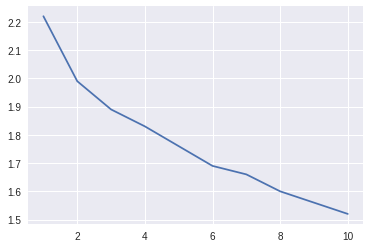

Test accuracy: training from scratch


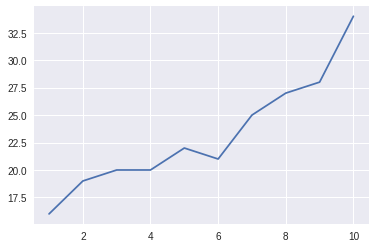

Training error: training from scratch


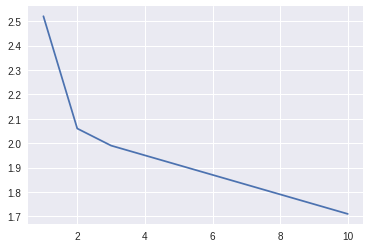

Test accuracy: training from scratch


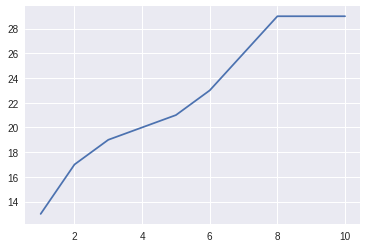

Training error: pretrained method 1


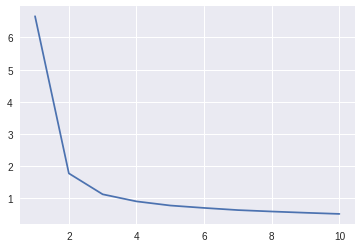

Test accuracy: pretrained method 1


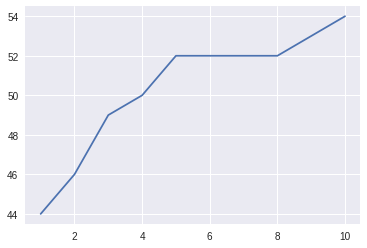

Training error: pretrained method 2


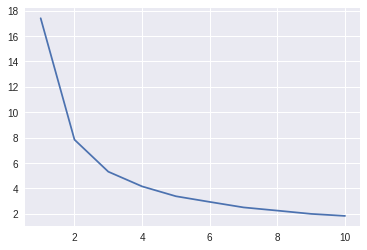

Test accuracy: pretrained method 2


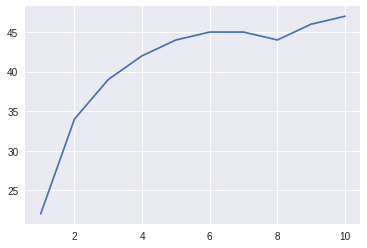

In [18]:
xaxis = np.array([1,2,3,4,5,6,7,8,9,10])
print("Training error: training from scratch")
plt.figure()
y = np.array([2.22,1.99,1.89,1.83,1.76,1.69,1.66,1.60,1.56,1.52])
plt.plot(xaxis,y)
plt.show()
print("Test accuracy: training from scratch")
plt.figure()
y = np.array([16,19,20,20,22,21,25,27,28,34])
plt.plot(xaxis,y)
plt.show()
print("Training error: training from scratch")
plt.figure()
y = np.array([2.52,2.06,1.99,1.95,1.91,1.87,1.83,1.79,1.75,1.71])
plt.plot(xaxis,y)
plt.show()
print("Test accuracy: training from scratch")
plt.figure()
y = np.array([13,17,19,20,21,23,26,29,29,29])
plt.plot(xaxis,y)
plt.show()

print("Training error: pretrained method 1")
plt.figure()
y = np.array([6.66,1.78,1.13,0.91,0.782,0.707,0.640,0.596,0.557,0.521])
plt.plot(xaxis,y)
plt.show()
print("Test accuracy: pretrained method 1")
plt.figure()
y = np.array([44,46,49,50,52,52,52,52,53,54])
plt.plot(xaxis,y)
plt.show()

print("Training error: pretrained method 2")
plt.figure()
y = np.array([17.4,7.835,5.313,4.154,3.378,2.933,2.5,2.248,1.99,1.83])
plt.plot(xaxis,y)
plt.show()
print("Test accuracy: pretrained method 2")
plt.figure()
y = np.array([22,34,39,42,44,45,45,44,46,47])
plt.plot(xaxis,y)
plt.show()